<a href="https://colab.research.google.com/github/durml91/MMath-Project/blob/duo-branch/Image_Diffusion_(working)/DiT%20Diffusion/copy_of_DiT-V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**DiT implementation**

### Imports and Installs

**Set float precision to 64 bit - doubles training time**

In [ ]:
# from jax.config import config; config.update("jax_enable_x64", True)

Need to install new version of Jax for package compatibility

In [ ]:
# !pip install jaxlib==0.4.2+cuda11.cudnn82 -f  https://storage.googleapis.com/jax-releases/jax_cuda_releases.html # [cuda]

In [ ]:
# !pip install --upgrade jax[cpu]

Install packages

In [1]:
!pip install diffrax
!pip install equinox
!pip install einops
!pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 KB 11.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 2.7.1
    Uninstalling typeguard-2.7.1:
      Successfully uninstalled typeguard-2.7.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 4.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 8.3 MB/s eta 0:00:00


Imports

In [2]:
import array
import functools as ft
import gzip
import os
import struct
import urllib.request

import diffrax as dfx  # https://github.com/patrick-kidger/diffrax
import einops  # https://github.com/arogozhnikov/einops
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

import equinox as eqx

**Generate rng key**

In [3]:
key = jr.PRNGKey(2023)

Setup for saving model parameters - only run once!

In [4]:
import shutil
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Data loader and data shuffler

In [7]:
!pip install emnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from emnist import extract_training_samples


def mnist():
    filename = "train-images-idx3-ubyte.gz"
    url_dir = "https://storage.googleapis.com/cvdf-datasets/mnist"
    target_dir = os.getcwd() + "/data/mnist"
    url = f"{url_dir}/{filename}"
    target = f"{target_dir}/{filename}"

    if not os.path.exists(target):
        os.makedirs(target_dir, exist_ok=True)
        urllib.request.urlretrieve(url, target)
        print(f"Downloaded {url} to {target}")

    with gzip.open(target, "rb") as fh:
        _, batch, rows, cols = struct.unpack(">IIII", fh.read(16))
        shape = (batch, 1, rows, cols)
        return jnp.array(array.array("B", fh.read()), dtype=jnp.uint8).reshape(shape)




def emnist():
  images, labels = extract_training_samples('balanced')
  qwep = einops.rearrange(images, "n h w -> n 1 h w")
  return jnp.array(qwep, dtype = jnp.uint8)



def cifar():
  from tensorflow.keras.datasets import cifar10
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()

  set1 = jnp.array(x_train)
  set2 = jnp.array(x_test)

  data = jnp.concatenate((set1, set2))

  data_reag = einops.rearrange(data, "n h w c -> n c h w")
  return data_reag


def dataloader(data, batch_size, *, key):
    dataset_size = data.shape[0]
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield data[batch_perm]
            start = end
            end = start + batch_size

### DiT Model

**Utility functions**

In [9]:
@eqx.filter_jit
def modulate(x, shift, scale):
    scale = jnp.expand_dims(scale, axis=1)       #scale is the value you mutliply your array by
    shift = jnp.expand_dims(shift, axis=1)       #shift is the value you move your array b                     
    return x * (1 + scale) + shift #1+scale to allow for zero scaling

    #e.g. by inputting (x, 0 ,0) you end up with x returned
    #this is just a very intuitive function!

In [10]:
@eqx.filter_jit
def get_2d_sincos_pos_embed(n_embd, grid_size):

    """grid_size: int value of grid height and width - we denote by (H, W)
       return pos_embed of dim (grid_size*grid_size, n_embd)"""
    

    grid_h = jnp.arange(grid_size, dtype=float)
    grid_w = jnp.arange(grid_size, dtype=float)
    grid = jnp.meshgrid(grid_w, grid_h)
    grid = jnp.stack(grid, axis=0)

    grid = jnp.reshape(grid, (2, 1, grid_size, grid_size))
    pos_embed = get_2d_sincos_pos_embed_from_grid(n_embd, grid)
    return pos_embed

#we basically end up with each patch embedding having a fixed n_embd dimensional sin/cos embedding vector - this is fixed! doesn't change based on sample but allows the NN to understand the "spatial" representation of the patches
##################################################################################

@eqx.filter_jit
def get_2d_sincos_pos_embed_from_grid(n_embd, grid):
    assert n_embd % 2 == 0

    emb_h = get_1d_sincos_pos_embed_from_grid(n_embd // 2, grid[0]) # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(n_embd // 2, grid[1]) # (H*W, D/2)

    emb = jnp.concatenate([emb_h, emb_w], axis=1)  #(H*W, D)
    return emb

#if we have a grid - think two rows of however many columns - we take each row and encode and get an positional embedding for each element in the row

##################################################################################

@eqx.filter_jit
def get_1d_sincos_pos_embed_from_grid(n_embd, pos):
    """n_embd is the output dimension for each position (D,)
       pos is an array of positions to be encoded of size (M,)
       size is of pos (M,D)"""
    
    assert n_embd % 2 == 0                
    omega = jnp.arange(n_embd // 2, dtype=float)   #generates an array from 0 to (n_embd // 2) - 1 of integer values    
    omega /= n_embd / 2         #divide by n_embd / 2 - can be thought of as normalising the values from to 0 to 1 i.e. uniform values
    omega = 1. / 10000**omega #(D/2) - so n_embd is D  
   
    pos = jnp.array(pos)
    out = jnp.outer(pos, omega)   #so we have pos^T * omega to make a matrix of dim (M, D/2)
    emb_sin = jnp.sin(out)   #dim (M, D/2)
    emb_cos = jnp.cos(out)   #dim (M, D/2)

    emb = jnp.concatenate([emb_sin, emb_cos], axis=1)  #dim (M, D) - join sin and cos column wise -> <-
    return emb


    #if we think of the input as a sequence of words and the respective n_embedding, then we are simply adding a positional embedding across each word in the sequence 

**NN modules**

In [11]:
#############################################
##############                ###############
##############    DiT model   ###############
##############                ###############
#############################################

"""Diffusion models meet Transformers!"""


###########   Time embedding    #############



###### Define silu activation ######

from typing import Callable

class Lambda1(eqx.Module):
    fn: Callable
    
    def __call__(self, x, *, key=None):
        return self.fn(x)

###### Time embedding ######

class TimeStepEmbedder(eqx.Module):
    mlp: eqx.nn.Sequential
    frequency_embedding_size: int
    
    def __init__(
        self,
        hidden_size,
        frequency_embedding_size,   #set as 256
        key
    ):
        l1key, l2key = jr.split(key, 2)
        self.mlp = eqx.nn.Sequential([
            eqx.nn.Linear(frequency_embedding_size, hidden_size, key=l1key),
            Lambda1(jax.nn.silu),
            eqx.nn.Linear(hidden_size, hidden_size, key=l2key)
        ])
        self.frequency_embedding_size = frequency_embedding_size

    def __call__(self, t, max_period=10000):
        dim = self.frequency_embedding_size
        half = dim // 2
        freqs = jnp.exp(
            -jnp.log(max_period) * jnp.arange(0, half, dtype=float) / half
        )
        args = t[:, None].astype(float) * freqs[None]
        embedding = jnp.concatenate([jnp.cos(args), jnp.sin(args)], axis=-1)
        if dim % 2:
            embedding = jnp.concatenate([embedding, jnp.zeros_like(embedding[:, :1])], axis=-1)
        t_freq = embedding
        t_emb = jax.vmap(self.mlp)(t_freq)
        return t_emb




##########   Multi-Head Attention   #########


class MultiAtt(eqx.Module):
    n_embed: int
    n_head: int
    mha: eqx.nn.MultiheadAttention

    def __init__(self, n_embed, n_head, key):
        self.n_embed = n_embed
        self.n_head = n_head
        assert self.n_embed % self.n_head ==0
        atkey, prkey, mhakey = jr.split(key, 3)
        self.mha = eqx.nn.MultiheadAttention(num_heads=self.n_head,
                                             query_size = self.n_embed,
                                             key_size=self.n_embed,
                                             value_size=self.n_embed,
                                             output_size=self.n_embed,
                                             use_query_bias=True,
                                             use_key_bias=True,
                                             use_value_bias=True,
                                             use_output_bias=True,
                                             key=mhakey)

    def __call__(self, x):
        values = jax.vmap(self.mha)(x, x, x)
        return values


##############    DiT Block     ##############


class DitBlock(eqx.Module):
    norm1: eqx.nn.LayerNorm
    norm2: eqx.nn.LayerNorm
    attn: eqx.Module
    Mlp: eqx.nn.MLP
    adaLN_modulation: eqx.nn.Sequential

    def __init__(
        self,
        hidden_size,
        n_head,
        mlp_ratio,   # = 4.0
        key,
    ):
        mkey, adakey = jr.split(key, 2)
        self.norm1 = eqx.nn.LayerNorm(hidden_size, eps = 1e-06, elementwise_affine=False)
        self.attn = MultiAtt(hidden_size, n_head=n_head, key=key)
        self.norm2 = eqx.nn.LayerNorm(hidden_size, eps = 1e-06, elementwise_affine=False)
        mlp_hidden_size = int(hidden_size * mlp_ratio)
        self.Mlp = eqx.nn.MLP(hidden_size, hidden_size, mlp_hidden_size, 1, key=mkey)
        self.adaLN_modulation = eqx.nn.Sequential([
            Lambda1(jax.nn.silu),
            eqx.nn.Linear(hidden_size, 6 * hidden_size, key=adakey)
        ])

    def __call__(self, x, t):
        temp = jax.vmap(self.adaLN_modulation)(t)
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = jnp.array_split(temp, 6, axis=1)
        
        
        gate_msa = jnp.expand_dims(gate_msa, axis=1)
        a = jax.vmap(self.norm1)(x)
        tem = modulate(a, shift_msa, scale_msa)
        x = x + gate_msa * self.attn(tem)
        
        
        gate_mlp = jnp.expand_dims(gate_mlp, axis=1)
        b = jax.vmap(self.norm2)(x)
        tems = modulate(b, shift_mlp, scale_mlp)     
        x = x + gate_mlp * jax.vmap(jax.vmap(self.Mlp))(tems)
        
        
        return x




#################   Final Layer   ################



class FinalLayer(eqx.Module):
    norm_final: eqx.nn.LayerNorm
    linear: eqx.nn.Linear
    #adaLN_modulation: eqx.nn.Linear
    adaLN_modulation: eqx.nn.Sequential
    
    def __init__(
        self,
        hidden_size,
        patch_size,
        out_channels,
        key
    ):
        lkey, adakey = jr.split(key, 2)
        self.norm_final = eqx.nn.LayerNorm(hidden_size, eps=1e-6, elementwise_affine=False)
        self.linear = eqx.nn.Linear(hidden_size, patch_size * patch_size * out_channels, key=lkey)
        #self.adaLN_modulation = eqx.nn.Linear(hidden_size, 2 * hidden_size, key=adakey)
        self.adaLN_modulation = eqx.nn.Sequential([
            Lambda1(jax.nn.silu),
            eqx.nn.Linear(hidden_size, 2 * hidden_size, key=adakey)
        ])

    def __call__(self, x, t):
        #t = jax.nn.silu(t)
        temp = jax.vmap(self.adaLN_modulation)(t)
        shift, scale = jnp.array_split(temp, 2, axis=1)
        x = modulate(self.norm_final(x), shift, scale)
        x = jax.vmap(jax.vmap(self.linear))(x)
        return x


###########   Patch embedding   ##############

class PatchEmbed(eqx.Module):
    num_patches:int
    proj: eqx.nn.Conv2d
    patch_size: int

    def __init__(
        self,
        img_size,
        patch_size,
        in_chans,
        n_embd,
        key
    ):
        patkey, _ = jr.split(key,2)
        self.patch_size = patch_size
        dg = img_size // self.patch_size
        self.num_patches = dg ** 2
        self.proj = eqx.nn.Conv2d(in_chans, n_embd, self.patch_size, self.patch_size, key=patkey)

    def __call__(self, x):
        B, C, H, W = x.shape
        x = jnp.array(x, dtype=float)
        x = jax.vmap(self.proj)(x)
        x = einops.rearrange(x, "B C H W -> B (H W) C")
        return x



###########   Parameter module    ##########

class Params(eqx.Module):
    param: jnp.ndarray

    def __init__(self, num_patches, hidden_size):
        self.param = jnp.zeros((1, num_patches, hidden_size), dtype = float)

    def __call__(self):
        return self.param


##########    DiT   ##########


class DiT(eqx.Module):
    in_channels: int
    out_channels: int
    patch_size: int
    n_head: int

    x_embedder: eqx.Module
    t_embedder: eqx.Module
    pos_embed: eqx.Module
    blocks: list
    final_layer: eqx.Module

    def __init__(
        self,
        input_size=28,
        patch_size=4,
        in_channels=1,
        hidden_size=384,
        depth=4,  
        n_head=6,  
        mlp_ratio=4.0,  #fixed
        frequency_embedding_size=256,   #fixed
        *,
        key=key,
        
    ):
        xkey, tkey, flkey, *dbkeys = jr.split(key, 3 + depth)
        self.in_channels = in_channels
        self.out_channels = in_channels
        self.patch_size = patch_size
        self.n_head = n_head
        self.x_embedder = PatchEmbed(input_size, patch_size, in_channels, hidden_size, key=xkey)
        self.t_embedder = TimeStepEmbedder(hidden_size, frequency_embedding_size, key=tkey)
        num_patches = self.x_embedder.num_patches
        self.pos_embed = Params(num_patches, hidden_size)
        self.blocks = [
            DitBlock(
                hidden_size, n_head, mlp_ratio, key = key
            )
            for dbkey in dbkeys                                   #_ in range(depth)           #*bkeys = jr.split(key, num_blocks)
        ]
        self.final_layer = FinalLayer(hidden_size, patch_size, self.out_channels, key=flkey)

        pos_embed = get_2d_sincos_pos_embed(self.pos_embed().shape[-1], int(self.x_embedder.num_patches ** 0.5))
        pos_embed = jnp.array(pos_embed, dtype=float)
        self.pos_embed = jnp.expand_dims(pos_embed, axis=0)
        
    
    def unpatchify(self, x):
        """
        x: (N, T, patch_size ** 2 * C)
        imgs: (N, H, W, C)
        """
        c = self.out_channels      
        p = self.x_embedder.patch_size 
        h = w = int(x.shape[1] ** 0.5)    
        x = jnp.reshape(x, (x.shape[0], h, w, p, p, c))
        x = einops.rearrange(x, "n h w p q c->n c h p w q")
        imgs = jnp.reshape(x, (x.shape[0], c, h * p, h * p))
        return imgs
    
    def __call__(self, x, t):
        #pos_embed = get_2d_sincos_pos_embed(self.pos_embed().shape[-1], int(self.x_embedder.num_patches ** 0.5))
        
        
        """
        x: (N, C, H, W)
        t: (N, )
        """
        #t = jnp.array([t], dtype=int)
        pdc = self.pos_embed.copy()
        x = self.x_embedder(x) + pdc # (N, T, D), where T = H * W / patch_size ** 2
        t = self.t_embedder(t)   # (N, D)
        for block in self.blocks:
            x = block(x,t)    # (N, T, D)
        x = self.final_layer(x, t)     # (N, T, patch_size ** 2 * out_channels) - N is the batch_size, T is the number of patches, 
        x = self.unpatchify(x)        # (N, out_channels, H, W)
        #x = jnp.squeeze(x, axis=0)
        return x

### Loss functions

In [ ]:
# def single_loss_fn(model, weight, int_beta, data, t, key):
#     mean = data * jnp.exp(-0.5 * int_beta(t))
#     var = jnp.maximum(1 - jnp.exp(-int_beta(t)), 1e-5)
#     std = jnp.sqrt(var)
#     noise = jr.normal(key, data.shape)
#     y = mean + std * noise
#     y = jnp.expand_dims(y, axis=0)
#     pred = model(y,t)
#     return weight(t) * jnp.mean((pred + noise / std) ** 2)


# def batch_loss_fn(model, weight, int_beta, data, t1, key):
#     batch_size = data.shape[0]
#     tkey, losskey = jr.split(key)
#     losskey = jr.split(losskey, batch_size)
#     # Low-discrepancy sampling over t to reduce variance
#     t = jr.uniform(tkey, (batch_size,), minval=0, maxval=t1 / batch_size)
#     t = t + (t1 / batch_size) * jnp.arange(batch_size)
#     loss_fn = ft.partial(single_loss_fn, model, weight, int_beta)
#     loss_fn = jax.vmap(loss_fn)
#     return jnp.mean(loss_fn(data, t, losskey))

In [12]:
def wb_loss_fn(model, weight, int_beta, data, t1, key):
    batch_size = data.shape[0]
    tkey, nkey = jr.split(key, 2)
    
    t = jr.uniform(tkey, (batch_size,), minval=0, maxval=t1 / batch_size)
    t = t + (t1 / batch_size) * jnp.arange(batch_size)
    bet = jnp.exp(-0.5 * jax.vmap(int_beta)(t))
    mean = jax.vmap(jnp.multiply)(data, bet)
    var = jnp.maximum(1 - jnp.exp(-jax.vmap(int_beta)(t)), 1e-5)
    std = jnp.sqrt(var)
    noise = jr.normal(nkey, data.shape)

    y = mean + jax.vmap(jnp.multiply)(std, noise)   #order of multiplcation doesn't matter
    pred = model(y,t)
    join = pred + noise
    js = jax.vmap(jnp.divide)(join, std)
    jss = js ** 2
    jsm = einops.reduce(jss, 'B C H W -> B', 'mean')
    
    wt = jax.vmap(weight)(t)
    ls = wt * jsm
    
    loss = jnp.mean(ls)
    return loss

### Update function

In [13]:
@eqx.filter_jit
def make_step(model, weight, int_beta, data, t1, key, opt_state, opt_update):
    loss_fn = eqx.filter_value_and_grad(wb_loss_fn)   #changed from batch_loss
    loss, grads = loss_fn(model, weight, int_beta, data, t1, key)
    updates, opt_state = opt_update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    key = jr.split(key, 1)[0]
    return loss, model, key, opt_state

### Sampler

In [14]:
@eqx.filter_jit
def single_sample_fn(model, int_beta, data_shape, dt0, t1, key):
    def drift(t, y, args):
        _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),))
        y = jnp.expand_dims(y, axis=0)
        
        t = jnp.array([t],dtype=int)
        
        c = -0.5 * beta * (y + model(y,t))
        
        c = jnp.squeeze(c, axis=0)
        return c

    term = dfx.ODETerm(drift)
    solver = dfx.Tsit5()
    t0 = 0
    y1 = jr.normal(key, data_shape)
    # reverse time, solve from t1 to t0
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1)
    return sol.ys[0]

### Training Loop

In [15]:
t1=10.0
# Optimisation hyperparameters
num_steps=1_000_000
lr=3e-4   
batch_size= 256
print_every= 5_000

In [16]:
data = emnist()
data_mean = jnp.mean(data)
data_std = jnp.std(data)
data_max = jnp.max(data)
data_min = jnp.min(data)
data_shape = data.shape[1:]
data = (data - data_mean) / data_std

In [31]:
loader_key, train_key, model_key, sample_key = jr.split(key, 4)

In [18]:
model_uni = DiT(key = model_key)

In [19]:
##########
### b ####
##########
def zero_init(weight: jax.Array) -> jax.Array:
  zw = jnp.zeros(weight.shape)
  return zw

def init_zero_weight(block, init_fn, key):
  
  get_weights = lambda block: [block.adaLN_modulation.layers[1].weight]
  weights = get_weights(block)
      
  new_weights = [init_fn(weight) for weight in weights]
  new_block = eqx.tree_at(get_weights, block, new_weights)


  return new_block

######################################
def change_w(model, init_fn, key):
  i=0
  for _ in model.blocks:
    model.blocks[i] = init_zero_weight(model.blocks[i], init_fn, key)

    i+=1
  #############  
  get_weights = lambda m: [m.final_layer.adaLN_modulation.layers[1].weight]
  weights = get_weights(model)
      
  new_weights = [init_fn(weight) for weight in weights]
  model = eqx.tree_at(get_weights, model, new_weights)
########################
  get_weights = lambda m: [m.final_layer.linear.weight]
  weights = get_weights(model)
      
  new_weights = [init_fn(weight) for weight in weights]
  model = eqx.tree_at(get_weights, model, new_weights)

  return model

model = change_w(model_uni, zero_init, key)

In [20]:
int_beta = lambda t: t  #
weight = lambda t: 1 - jnp.exp(-int_beta(t))  

In [21]:
opt = optax.adabelief(lr)

opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

In [22]:
from pickle import dump, load
lossdict = {}

In [23]:
total_value = 0
total_size = 0
for step, data in zip(range(num_steps), dataloader(data, batch_size, key=loader_key)): 
    value, model, train_key, opt_state = make_step(model, weight, int_beta, data, t1, train_key, opt_state, opt.update)
    total_value += value.item()
    total_size += 1
    if (step % print_every) == 0 or step == num_steps - 1:
        print(f"Step={step} Loss={total_value / total_size}")
        lossdict[step] = (total_value / total_size)
        total_value = 0
        total_size = 0

Step=0 Loss=0.9991881847381592
Step=5000 Loss=0.021048970002867283
Step=10000 Loss=0.014903312004357577
Step=15000 Loss=0.014178116141445934
Step=20000 Loss=0.013792958230152726
Step=25000 Loss=0.013518659477680921
Step=30000 Loss=0.013372329498641193
Step=35000 Loss=0.013202725858613849
Step=40000 Loss=0.013091450021974742
Step=45000 Loss=0.013002076457254588
Step=50000 Loss=0.012913280752114951
Step=55000 Loss=0.012833459752611815
Step=60000 Loss=0.012766578601300716
Step=65000 Loss=0.012718304555490613
Step=70000 Loss=0.012664208235405386
Step=75000 Loss=0.012601834873110056
Step=80000 Loss=0.012572192812152208
Step=85000 Loss=0.012521640135906637
Step=90000 Loss=0.012493690461665392
Step=95000 Loss=0.012470489009097219
Step=100000 Loss=0.012436568923294544
Step=105000 Loss=0.012404556060396135
Step=110000 Loss=0.012369708841666579
Step=115000 Loss=0.012350497869029642
Step=120000 Loss=0.012330441507324576
Step=125000 Loss=0.012304268783330918
Step=130000 Loss=0.01227672838140279
St

KeyboardInterrupt: ignored

**Early stopping code**

In [ ]:
# total_value = 0
# total_size = 0
# losses = [0]
# i=0
# ls=2


# for step, data in zip(range(num_steps), dataloader(data, batch_size, key=loader_key)):
#         value, model, train_key, opt_state = make_step(model, weight, int_beta, data, t1, train_key, opt_state, opt.update)
#         total_value += value.item()
#         total_size += 1

#         if (step % print_every) == 0 or step == num_steps - 1:
              
#             print(f"Step={step} Loss={total_value / total_size}")
#             lossdict[step] = (total_value / total_size)
#             if step != 0 :
#                 ls = total_value / total_size
#                 if jnp.absolute(ls - losses[i]) > 5e-5:
#                     i += 1
#                     losses.append(ls)
#                 else:
#                     print("Early stopping intervened")
#                     break
#             else:
#                 continue
#             total_value = 0
#             total_size = 0

**Save model**

In [24]:
eqx.tree_serialise_leaves("DiT_emnist.eqx", model)
shutil.copy('/content/DiT_emnist.eqx','/content/gdrive/MyDrive/Colab_Notebooks')

'/content/gdrive/MyDrive/Colab_Notebooks/DiT_emnist.eqx'

**Save losses**

In [25]:
with open('./DiT_emnist_losses.pkl', 'wb') as file:
    dump(lossdict, file)

import shutil
shutil.copy('./DiT_emnist_losses.pkl','/content/gdrive/MyDrive/Colab_Notebooks')

'/content/gdrive/MyDrive/Colab_Notebooks/DiT_emnist_losses.pkl'

### Sampling

In [29]:
sample_size = 6
dt0 = 0.01

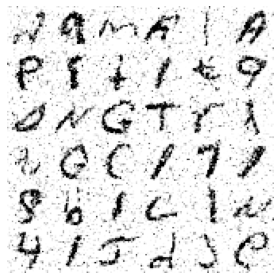

In [32]:
sample_key = jr.split(sample_key, sample_size**2)
sample_fn = ft.partial(single_sample_fn, model, int_beta, data_shape, dt0, t1)
sample = jax.vmap(sample_fn)(sample_key)
sample = data_mean + data_std * sample
sample = jnp.clip(sample, data_min, data_max)
sample = einops.rearrange(sample, "(n1 n2) 1 h w -> (n1 h) (n2 w)", n1=sample_size, n2=sample_size)
plt.imshow(sample, cmap="Greys")
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
sample_key = jr.split(sample_key, sample_size**2)
sample_fn = ft.partial(single_sample_fn, model, int_beta, data_shape, dt0, t1)
sample = jax.vmap(sample_fn)(sample_key)
sample = data_mean + data_std * sample
sample = jnp.clip(sample, data_min, data_max)
sample1 = sample[:, 0, :, :]
sample2 = sample[:, 1, :, :]
sample3 = sample[:, 2, :, :]
   
sample1 = einops.rearrange(sample1, "(n1 n2) h w -> (n1 h) (n2 w) ", n1=sample_size, n2=sample_size)
sample2 = einops.rearrange(sample2, "(n1 n2) h w -> (n1 h) (n2 w) ", n1=sample_size, n2=sample_size)
sample3 = einops.rearrange(sample3, "(n1 n2) h w -> (n1 h) (n2 w) ", n1=sample_size, n2=sample_size)

sample1 = sample1[None,:,:]
sample2 = sample2[None,:,:]
sample3 = sample3[None,:,:]
    
newsamp = jnp.concatenate([sample1, sample2, sample3])
sample = einops.rearrange(newsamp, "c h w -> h w c")
sample = jnp.array(sample, dtype=int)
    
    
plt.imshow(sample)
plt.axis("off")
plt.tight_layout()
plt.show()
     

**Loss curve**

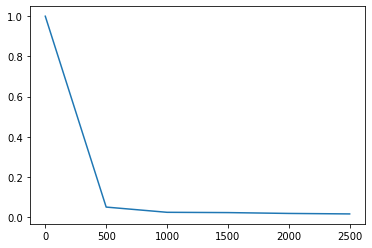

In [ ]:
#test = load(open('./test_to_delete.pkl', 'rb'))

import matplotlib.pylab as plt
myList = lossdict.items()
myList = sorted(myList) 
x, y = zip(*myList) 

plt.plot(x, y)
plt.show()

In [ ]:
a = lossdict.copy()

In [ ]:
del a[0]

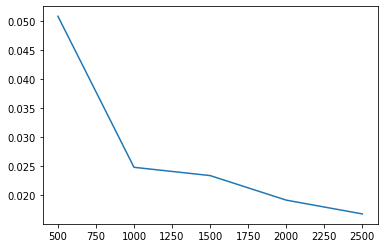

In [ ]:
#test = load(open('./test_to_delete.pkl', 'rb'))

import matplotlib.pylab as plt
myList = a.items()
myList = sorted(myList) 
x, y = zip(*myList) 

plt.plot(x, y)
plt.show()

**Load Model**

In [ ]:
loaded_model = eqx.tree_deserialise_leaves('/content/gdrive/MyDrive/Colab_Notebooks/DiT_mnist.eqx', model)